In [9]:
from typing import (Callable, Dict, Generic, Literal, Protocol, Tuple, TypeVar,
                    Union)

import numpy as np
import numpy.typing as npt

np.set_printoptions(precision=4, suppress=True)


# Define type variables and protocols
T = TypeVar("T", float, npt.NDArray[np.float64])


class ODEFunction(Protocol, Generic[T]):
    def __call__(self, t: float, y: T) -> T: ...


class StepMethod(Protocol, Generic[T]):
    def __call__(self, i: int) -> T: ...


def _create_methods(
    w: Union[npt.NDArray[np.float64], npt.NDArray[np.float64]],
    t: npt.NDArray[np.float64],
    h: float,
    f: ODEFunction[T],
    vector_form: bool = False,
) -> Dict[str, Callable[[int], T]]:
    """
    Create numerical integration step methods.

    Parameters
    ----------
    w : Union[npt.NDArray[np.float64], npt.NDArray[np.float64]]
        Array to store solution values.
    t : npt.NDArray[np.float64]
        Array of time points.
    h : float
        Step size.
    f : ODEFunction[T]
        Function defining the ODE.
    vector_form : bool, optional
        Whether to use vector form, by default False

    Returns
    -------
    Dict[str, Callable[[int], T]]
        Dictionary of numerical methods.
    """

    def euler(i: int) -> T:
        """Euler's method (first-order)."""
        return w[i] + h * np.array(f(t[i], w[i]))

    def eulermod(i: int) -> T:
        """Modified Euler's method (second-order)."""
        k1 = np.array(f(t[i], w[i]))
        k2 = np.array(f(t[i + 1], w[i] + h * k1))
        return w[i] + (h / 2) * (k1 + k2)

    def heun(i: int) -> T:
        """Heun's third-order method."""
        k1 = np.array(f(t[i], w[i]))
        k2 = np.array(f(t[i] + h / 3, w[i] + (h / 3) * k1))
        k3 = np.array(f(t[i] + 2 * h / 3, w[i] + (2 * h / 3) * k2))

        return w[i] + (h / 4) * (k1 + 3 * k3)

    def midpoint(i: int) -> T:
        """Midpoint method (second-order)."""
        return w[i] + h * f(t[i] + h / 2, w[i] + (h / 2) * f(t[i], w[i]))

    def rk4(i: int) -> T:
        """Classical fourth-order Runge-Kutta method."""
        k1 = h * np.array(f(t[i], w[i]))
        k2 = h * np.array(f(t[i] + h / 2, w[i] + k1 / 2))
        k3 = h * np.array(f(t[i] + h / 2, w[i] + k2 / 2))
        k4 = h * np.array(f(t[i + 1], w[i] + k3))
        return w[i] + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    return {
        "euler": euler,
        "eulermod": eulermod,
        "heun": heun,
        "midpoint": midpoint,
        "rk4": rk4,
    }


def scalar_ode(
    f: Callable[[float, float], float],
    a: float,
    b: float,
    alpha: float,
    n: int,
    method: Literal["euler", "eulermod", "heun", "midpoint", "rk4"],
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """
    Solve a scalar first-order ordinary differential equation (ODE) using various numerical methods.

    Solves the initial value problem:
        y'(t) = f(t, y(t))
        y(a) = alpha
    on the interval [a, b].

    Parameters
    ----------
    f : Callable[[float, float], float]
        The function defining the ODE, f(t, y) returns the value of y'(t).
    a : float
        The left endpoint of the integration interval.
    b : float
        The right endpoint of the integration interval.
    alpha : float
        The initial value y(a).
    n : int
        The number of subintervals to divide [a, b] into.
    method : Literal["euler", "eulermod", "heun", "midpoint", "rk4"]
        The numerical integration method to use:
        - "euler": Euler's method (first-order)
        - "eulermod": Modified Euler's method (second-order)
        - "heun": Heun's method (third-order)
        - "midpoint": Midpoint method (second-order)
        - "rk4": Classical fourth-order Runge-Kutta method

    Returns
    -------
    Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]
        A tuple containing:
        - t: Array of time points
        - w: Array of approximate solution values at the time points

    Raises
    ------
    ValueError
        If an invalid method name is provided.

    Examples
    --------
    Solving the ODE y'(t) = y(t) with initial condition y(0) = 1,
    which has the exact solution y(t) = e^t:

    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> from pvi_scalar import solve_ode
    >>>
    >>> # Define the ODE function: y'(t) = y(t)
    >>> def f(t, y):
    ...     return y
    >>>
    >>> # Solve using RK4 method
    >>> t, y_rk4 = solve_ode(f, a=0, b=1, alpha=1, n=100, method="rk4")
    >>>
    >>> # Compare with exact solution
    >>> y_exact = np.exp(t)
    >>>
    >>> # Calculate error
    >>> max_error = np.max(np.abs(y_rk4 - y_exact))
    >>> print(f"Maximum error with RK4: {max_error:.2e}")
    Maximum error with RK4: 4.48e-10
    >>>
    >>> # Plot results
    >>> plt.figure(figsize=(10, 6))
    >>> plt.plot(t, y_exact, 'k-', label='Exact')
    >>> plt.plot(t, y_rk4, 'r--', label='RK4')
    >>> plt.title("Solution of y' = y with y(0) = 1")
    >>> plt.xlabel("t")
    >>> plt.ylabel("y(t)")
    >>> plt.legend()
    >>> plt.grid(True)
    >>> plt.show()

    Comparing multiple methods for the ODE y'(t) = -2ty(t) with initial condition y(0) = 1,
    which has the exact solution y(t) = e^(-t²):

    >>> # Define the ODE: y'(t) = -2ty(t)
    >>> def f(t, y):
    ...     return -2 * t * y
    >>>
    >>> # Solve using different methods
    >>> t, y_euler = solve_ode(f, a=0, b=2, alpha=1, n=50, method="euler")
    >>> t, y_rk4 = solve_ode(f, a=0, b=2, alpha=1, n=50, method="rk4")
    >>>
    >>> # Exact solution
    >>> y_exact = np.exp(-t**2)
    >>>
    >>> # Plot comparison
    >>> plt.figure(figsize=(10, 6))
    >>> plt.plot(t, y_exact, 'k-', label='Exact')
    >>> plt.plot(t, y_euler, 'b--', label='Euler')
    >>> plt.plot(t, y_rk4, 'r--', label='RK4')
    >>> plt.title("Solution of y' = -2ty with y(0) = 1")
    >>> plt.xlabel("t")
    >>> plt.ylabel("y(t)")
    >>> plt.legend()
    >>> plt.grid(True)
    >>> plt.show()
    """
    if n <= 0:
        raise ValueError("Number of subintervals must be positive")
    if b <= a:
        raise ValueError("Right endpoint must be greater than left endpoint")

    h: float = (b - a) / n
    t: npt.NDArray[np.float64] = np.linspace(a, b, n + 1, dtype=np.float64)
    w: npt.NDArray[np.float64] = np.zeros(n + 1, dtype=np.float64)
    w[0] = alpha

    # Get numerical methods
    methods = _create_methods(w, t, h, f, vector_form=False)

    # Ensure the method exists
    if method not in methods:
        raise ValueError(f"Unknown method: {method}")

    # Use the selected method
    for i in range(n):
        w[i + 1] = methods[method](i)

    return t, w


def vector_ode(
    F: Callable[[float, npt.NDArray[np.float64]], npt.NDArray[np.float64]],
    a: float,
    b: float,
    alpha: npt.NDArray[np.float64],
    n: int,
    method: Literal["euler", "eulermod", "heun", "midpoint", "rk4"],
) -> Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """
    Solve a system of first-order ordinary differential equations (ODEs) using various numerical methods.

    Solves the initial value problem:
        Y'(t) = F(t, Y(t))
        Y(a) = alpha
    on the interval [a, b], where Y is a vector-valued function.

    Parameters
    ----------
    F : Callable[[float, npt.NDArray[np.float64]], npt.NDArray[np.float64]]
        The function defining the ODE system, F(t, Y) returns the value of Y'(t).
    a : float
        The left endpoint of the integration interval.
    b : float
        The right endpoint of the integration interval.
    alpha : npt.NDArray[np.float64]
        The initial value Y(a) as a numpy array.
    n : int
        The number of subintervals to divide [a, b] into.
    method : Literal["euler", "eulermod", "heun", "midpoint", "rk4"]
        The numerical integration method to use:
        - "euler": Euler's method (first-order)
        - "eulermod": Modified Euler's method (second-order)
        - "heun": Heun's method (third-order)
        - "midpoint": Midpoint method (second-order)
        - "rk4": Classical fourth-order Runge-Kutta method

    Returns
    -------
    Tuple[npt.NDArray[np.float64], npt.NDArray[np.float64]]
        A tuple containing:
        - t: Array of time points
        - W: Array of approximate solution values at the time points, shape (n+1, dimension of Y)

    Raises
    ------
    ValueError
        If an invalid method name is provided, number of subintervals is not positive,
        or if the integration interval is invalid.
    """
    if n <= 0:
        raise ValueError("Number of subintervals must be positive")
    if b <= a:
        raise ValueError("Right endpoint must be greater than left endpoint")

    # Convert alpha to numpy array if it's a list
    alpha_array = np.array(alpha, dtype=np.float64)

    h: float = (b - a) / n
    t: npt.NDArray[np.float64] = np.linspace(a, b, n + 1, dtype=np.float64)
    W: npt.NDArray[np.float64] = np.zeros((n + 1, len(alpha_array)), dtype=np.float64)
    W[0] = alpha_array

    # Get numerical methods
    methods = _create_methods(W, t, h, F, vector_form=True)

    # Ensure the method exists
    if method not in methods:
        raise ValueError(f"Unknown method: {method}")

    # Use the selected method
    for i in range(n):
        W[i + 1] = methods[method](i)

    return t, W


In [10]:
from typing import Callable, Tuple
import numpy as np

def ls(
    p: Callable[[float], float],
    q: Callable[[float], float],
    r: Callable[[float], float],
    a: float,
    b: float,
    alpha: float,
    beta: float,
    n: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Solves a second-order linear boundary value problem using the shooting method.

    The boundary value problem is of the form:
    y'' + p(t)y' + q(t)y = r(t)
    with boundary conditions y(a) = alpha, y(b) = beta

    Parameters
    ----------
    p : callable[[float], float]
        Function p(t) in the differential equation.
    q : callable[[float], float]
        Function q(t) in the differential equation.
    r : callable[[float], float]
        Function r(t) in the differential equation.
    a : float
        Left boundary point.
    b : float
        Right boundary point.
    alpha : float
        Boundary condition at a (y(a) = alpha).
    beta : float
        Boundary condition at b (y(b) = beta).
    n : int
        Number of intervals to divide [a, b] into.

    Returns
    -------
    t : np.ndarray
        Array of mesh points from a to b.
    w : np.ndarray
        Approximation to the solution y at the mesh points.

    Notes
    -----
    The method uses Runge-Kutta 4th order (rk4) method for solving the initial value problems.

    Example
    -------
    >>> import numpy as np
    >>> from functions.boundary_value import linear_shot
    >>> from scipy.special import j0  # Bessel function of the first kind
    >>>
    >>> # Example: y'' + (1/t)y' + y = 0 with boundary conditions y(1) = j0(1), y(2) = j0(2)
    >>> # This has the exact solution y(t) = j0(t)
    >>> def p(t): return 1/t
    >>> def q(t): return 1
    >>> def r(t): return 0
    >>>
    >>> a, b = 1, 2
    >>> alpha, beta = j0(1), j0(2)
    >>> n = 100
    >>>
    >>> t, w = linear_shot(p, q, r, a, b, alpha, beta, n)
    >>>
    >>> # Compare with exact solution
    >>> exact = j0(t)
    >>> max_error = np.max(np.abs(w - exact))
    >>> print(f"Maximum error: {max_error:.6e}")
    """
    h = (b - a) / n

    w = np.zeros(n + 1)
    t = np.linspace(a, b, n + 1)

    def F1(t, u):
        return np.array([u[1], q(t) * u[0] + p(t) * u[1] + r(t)])

    def F2(t, v):
        return np.array([v[1], q(t) * v[0] + p(t) * v[1]])

    _, yu = vector_ode(F1, a, b, [alpha, 0], n, "rk4")
    _, yv = vector_ode(F2, a, b, [0, 1], n, "rk4")

    u = yu[:, 0]
    v = yv[:, 0]

    for i in range(n + 1):
        w[i] = u[i] + (beta - u[n]) * v[i] / v[n]

    return t, w

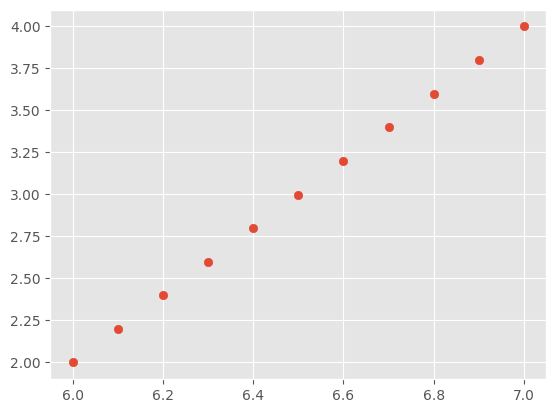

In [ ]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# definimos las funciones p(x), q(x) y r(x)
p = lambda x: np.exp(-x) * np.sin(6 * x) + np.log(x** + 6)
q = lambda x: np.exp(-x) * np.arctan(x)
r = lambda x: np.exp(-x) * np.cos(3 * x)

# definimos las cotas del intervalo
a = 6
b = 7

# definimos las condiciones de frontera
alpha = 2
beta = 4

h = 0.1
n = int((b - a) / h)

t, w = ls(p, q, r, a, b, alpha, beta, n)

plt.scatter(t,w)
plt.show()
